<a href="https://colab.research.google.com/github/dnbaohan/graduation_thesis/blob/Hybrid-Fourier-Domain-and-Deep-Learning-Approaches-for-Financial-Market-Forecasting-and-Pattern-Recognition/FFT%2BLSTM%20of%20banking%20portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries and Setup

In [1]:
# Install required libraries
!pip install yfinance --quiet
!pip install scikit-learn --quiet
!pip install scikeras --quiet
!pip install tensorflow pandas numpy matplotlib --quiet
!pip install TA-Lib --quiet

In [2]:
# Import libraries
import os
import math
import pywt
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Attention, Add, Dense, Input, MultiHeadAttention, BatchNormalization
from tensorflow.keras.models import Model

import talib  # Technical Analysis Library

# Set plotting configuration
plt.rcParams["figure.figsize"] = (15, 8)
warnings.filterwarnings("ignore")
np.random.seed(0)

# Create directories for results
os.makedirs("results/models", exist_ok=True)
os.makedirs("results/plots", exist_ok=True)

# Data Preparation

In [3]:
# Define the portfolio tickers and date range
tickers = ["VCB.VN", "CTG.VN", "BID.VN", "TCB.VN", "MBB.VN"]
start_date = "2020-01-01"
end_date   = "2025-01-01"

In [4]:
def clean_yfinance_multiindex(data: pd.DataFrame) -> pd.DataFrame:
    """Clean yfinance multi-index columns and flatten them."""
    if data is None or data.shape[0] == 0:
        return data  # return empty as-is

    # Flatten multi-index columns if present
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = [col[0] if col[0] != "" else col[1] for col in data.columns]
    # Remove any header rows that are ticker symbols
    try:
        if data.iloc[0].astype(str).str.fullmatch(r"[A-Z]+").any():
            data = data.iloc[1:].reset_index(drop=True)
    except IndexError:
        return pd.DataFrame()  # return empty if indexing fails

    # Standardize column names
    rename_map = {"Date":"Date", "Open":"Open", "High":"High", "Low":"Low", "Close":"Close", "Volume":"Volume"}
    data = data.rename(columns=rename_map)
    # Ensure Date is datetime
    if "Date" in data.columns:
        data["Date"] = pd.to_datetime(data["Date"])
    # Convert price/volume columns to numeric
    for col in ["Open","High","Low","Close","Volume"]:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors="coerce")
    # Drop rows with NaN Close or Date
    if "Date" in data.columns and "Close" in data.columns:
        data = data.dropna(subset=["Date","Close"])
    # Sort by date
    if "Date" in data.columns:
        data = data.sort_values("Date").reset_index(drop=True)
    return data

In [5]:
def create_sequences(X, y, seq_len):
    X_seq, y_seq = [], []
    for i in range(seq_len, len(X)):
        X_seq.append(X[i-seq_len:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

# Data Preprocessing

In [8]:
# Container to collect evaluation metrics for all models and stocks
all_metrics = []

for ticker in tickers:
    # Download historical data for the stock
    data = yf.download(ticker, start=start_date, end=end_date)
    data = data.reset_index()               # Convert index to column for uniform processing
    data = clean_yfinance_multiindex(data)  # Clean and standardize columns
    print(f"There are {data.shape[0]} days in the {ticker} dataset.")

    # Compute log returns and percentage change
    data["Log_Return"] = np.log(data["Close"] / data["Close"].shift(1))
    data["Pct_Change"] = data["Close"].pct_change()
    data = data.dropna().reset_index(drop=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


There are 1250 days in the VCB.VN dataset.
There are 1246 days in the CTG.VN dataset.


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


There are 1250 days in the BID.VN dataset.
There are 1247 days in the TCB.VN dataset.


[*********************100%***********************]  1 of 1 completed

There are 1250 days in the MBB.VN dataset.


# Evaluation Model

In [6]:
    def evaluate_model(model, X_train_seq, y_train_seq, X_test_seq, y_test_seq, name="", plot=True):
        # Predict on train and test sets
        y_pred_train = model.predict(X_train_seq, verbose=0).squeeze()
        y_pred_test  = model.predict(X_test_seq,  verbose=0).squeeze()
        # Store actual and predicted returns for later comparison
        actual_returns = y_test_seq
        predicted_returns = y_pred_test

        # Regression metrics
        mse  = mean_squared_error(y_test_seq, y_pred_test)
        rmse = np.sqrt(mse)
        mae  = mean_absolute_error(y_test_seq, y_pred_test)
        # r2   = r2_score(y_test_seq, y_pred_test)
        # Directional metrics
        actual_dir = np.sign(y_test_seq[1:] - y_test_seq[:-1])   # actual direction of change
        pred_dir   = np.sign(y_pred_test[1:] - y_pred_test[:-1]) # predicted direction
        dir_acc = (actual_dir == pred_dir).mean() if len(actual_dir) > 0 else np.nan
        actual_sign = (y_test_seq >= 0).astype(int)
        pred_sign   = (y_pred_test >= 0).astype(int)
        hit_ratio   = (actual_sign == pred_sign).mean()
        precision   = precision_score(actual_sign, pred_sign)
        recall      = recall_score(actual_sign, pred_sign)
        f1          = f1_score(actual_sign, pred_sign)
        auc_roc     = roc_auc_score(actual_sign, pred_sign)
        cm          = confusion_matrix(actual_sign, pred_sign, labels=[0, 1])
        cls_report  = classification_report(actual_sign, pred_sign, target_names=["Giảm","Tăng"], digits=4)
        # Print evaluation results
        print(f"=== Evaluation Metrics for {name} ===")
        print(f"MSE: {mse:.6f},  RMSE: {rmse:.6f},  MAE: {mae:.6f}")
        print(f"Directional Accuracy: {dir_acc:.4f},  Hit Ratio: {hit_ratio:.4f}")
        print(f"Precision (Up): {precision:.4f}, Recall (Up): {recall:.4f}, F1-Score: {f1:.4f}")
        # print(f"R²       : {r2:,.6f}")
        print(f"AUC-ROC: {auc_roc:.4f}")
        print("Confusion Matrix (0=Down, 1=Up):\n", cm)
        print("Classification Report:\n", cls_report)
        # Plot actual vs predicted returns if requested
        if plot:
            plt.figure(figsize=(12,5))
            plt.plot(y_test_seq, label="Actual Return", linewidth=2)
            plt.plot(y_pred_test, label="Predicted Return", linewidth=2)
            plt.title(name)
            plt.xlabel("Time")
            plt.ylabel("Return")
            plt.legend()
            plt.grid(alpha=0.3)
            plt.show()
        # Return metrics in a dictionary for later use
        return {
            "mse": mse, "rmse": rmse, "mae": mae,
            "directional_accuracy": dir_acc, "hit_ratio": hit_ratio,
            "precision": precision, "recall": recall, "f1": f1,
            "auc_roc": auc_roc,
            # "r2": r2,
            "actual_returns": actual_returns, "predicted_returns": predicted_returns # Added these lines
        }

# Transformer Model

In [17]:
# ===============================
# Transformer Model (FIXED)
# ===============================

LOOKBACK = 30

def transformer_features(df):
    df = df.copy()
    df["Return"] = df["Log_Return"]

    df["RSI"] = talib.RSI(df["Return"].values, timeperiod=14)
    df["MACD"], df["MACD_signal"], _ = talib.MACD(
        df["Return"].values, fastperiod=12, slowperiod=26, signalperiod=9
    )
    df["BB_upper"], df["BB_middle"], df["BB_lower"] = talib.BBANDS(
        df["Return"].values, timeperiod=20
    )

    df["EMA_12"] = df["Return"].ewm(span=12).mean()
    df["EMA_26"] = df["Return"].ewm(span=26).mean()
    df["MA_5"]   = df["Return"].rolling(5).mean()

    df["Vol_5"]  = df["Return"].rolling(5).std()
    df["Vol_10"] = df["Return"].rolling(10).std()
    df["Vol_20"] = df["Return"].rolling(20).std()

    df["Trend_20"] = df["Return"].rolling(20).mean()
    df["Regime"]   = (df["Vol_20"] > df["Vol_20"].rolling(60).mean()).astype(int)

    return df.dropna()

# ---------- Feature Engineering ----------
df_trans = transformer_features(data)

FEATURES = [
    'Return', 'RSI', 'MACD', 'MACD_signal',
    'BB_upper', 'BB_middle', 'BB_lower',
    'EMA_12', 'EMA_26', 'MA_5',
    'Vol_5', 'Vol_10', 'Vol_20',
    'Trend_20', 'Regime'
]

X_raw = df_trans[FEATURES].values
y_raw = df_trans["Log_Return"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

X_seq, y_seq = create_sequences(X_scaled, y_raw, LOOKBACK)

split_idx = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# ---------- Positional Encoding ----------
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super().__init__()

        pos = np.arange(position)[:, np.newaxis]
        i   = np.arange(d_model)[np.newaxis, :]

        angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
        angle_rads  = pos * angle_rates

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.constant(
            angle_rads[np.newaxis, ...], dtype=tf.float32
        )

    def call(self, x):
        return x + self.pos_encoding[:, :tf.shape(x)[1], :]

# ---------- Transformer Encoder ----------
def transformer_encoder(x, head_size, num_heads, ff_dim, dropout=0.2):
    attn = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=head_size, dropout=dropout
    )(x, x)

    x = tf.keras.layers.Add()([x, attn])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    ff = tf.keras.layers.Dense(ff_dim, activation="relu")(x)
    ff = tf.keras.layers.Dropout(dropout)(ff)
    ff = tf.keras.layers.Dense(tf.keras.backend.int_shape(x)[-1])(ff)

    x = tf.keras.layers.Add()([x, ff])
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    return x

# ---------- Build Model ----------
def build_transformer(
    input_shape,
    head_size=64,
    num_heads=8,
    ff_dim=128,
    num_blocks=4,
    dropout=0.2
):
    inputs = tf.keras.Input(shape=input_shape)
    x = PositionalEncoding(input_shape[0], input_shape[1])(inputs)

    for _ in range(num_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = tf.keras.layers.Dense(1)(x)

    return tf.keras.Model(inputs, outputs)

# ---------- Compile ----------
model_transformer = build_transformer(
    input_shape=(LOOKBACK, X_train.shape[2]),
    num_heads=8,
    num_blocks=4
)

lr_schedule = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=20000,
    decay_rate=0.9,
    staircase=True
)

model_transformer.compile(
    optimizer=Adam(learning_rate=lr_schedule),
    loss="mse"
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

history_trans = model_transformer.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop],
    verbose=0
)


## Evaluate Transformer Model

In [18]:
metrics_trans = evaluate_model(model_transformer, X_train, y_train, X_test, y_test, name=f"Transformer: {ticker}", plot=False)
metrics_trans["Stock"] = ticker
metrics_trans["Model"] = "Transformer"
all_metrics.append(metrics_trans)

=== Evaluation Metrics for Transformer: MBB.VN ===
MSE: 0.000287,  RMSE: 0.016932,  MAE: 0.012569
Directional Accuracy: 0.5738,  Hit Ratio: 0.5042
Precision (Up): 0.5474, Recall (Up): 0.5725, F1-Score: 0.5597
AUC-ROC: 0.4965
Confusion Matrix (0=Down, 1=Up):
 [[45 62]
 [56 75]]
Classification Report:
               precision    recall  f1-score   support

        Giảm     0.4455    0.4206    0.4327       107
        Tăng     0.5474    0.5725    0.5597       131

    accuracy                         0.5042       238
   macro avg     0.4965    0.4965    0.4962       238
weighted avg     0.5016    0.5042    0.5026       238



# Baseline LSTM Model

In [15]:
    # === Baseline LSTM Model for this stock ===
    def lstm_features_baseline(df):
        df = df.copy()
        df["Return"] = df["Log_Return"]
        # Technical indicators for baseline
        df["RSI"] = talib.RSI(df["Return"].values, timeperiod=14)
        df["MACD"], df["MACD_signal"], _ = talib.MACD(df["Return"].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df["BB_upper"], df["BB_middle"], df["BB_lower"] = talib.BBANDS(df["Return"].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df["EMA_12"] = df["Return"].ewm(span=12, adjust=False).mean()
        df["EMA_26"] = df["Return"].ewm(span=26, adjust=False).mean()
        df["MA_5"]   = df["Return"].rolling(5).mean()
        df["Vol_5"]  = df["Return"].rolling(5).std()
        df["Vol_10"] = df["Return"].rolling(10).std()
        df['Stochastic_Oscillator'] = talib.STOCH(df['High'], df['Low'], df['Close'], fastk_period=14, slowk_period=3, slowk_matype=0)[0]
        df['Average_True_Range'] = talib.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
        df['On_Balance_Volume'] = talib.OBV(df['Close'], df['Volume'])
        return df.dropna()

    df_base = lstm_features_baseline(data)
    features_baseline = [
    "Return", "EMA_12", "EMA_26", "Vol_5", "Vol_10", "MACD", "RSI", "BB_upper", "BB_lower",
    "Stochastic_Oscillator", "Average_True_Range", "On_Balance_Volume"
]
    X_base = df_base[features_baseline].values
    y_base = df_base["Return"].values

    # Train-test split (80/20)
    split_idx = int(len(X_base) * 0.8)
    X_train_base, X_test_base = X_base[:split_idx], X_base[split_idx:]
    y_train_base, y_test_base = y_base[:split_idx], y_base[split_idx:]
    # Scale features
    scaler_base = StandardScaler()
    X_train_scaled = scaler_base.fit_transform(X_train_base)
    X_test_scaled  = scaler_base.transform(X_test_base)
    SEQ_LEN = 30
    X_train_seq_base, y_train_seq_base = create_sequences(X_train_scaled, y_train_base, SEQ_LEN)
    X_test_seq_base, y_test_seq_base   = create_sequences(X_test_scaled,  y_test_base,  SEQ_LEN)

    # Build the baseline LSTM model (bidirectional LSTMs + attention)
    from tensorflow.keras.layers import LSTM, Bidirectional, Attention, Dense, Dropout, Input
    from tensorflow.keras.models import Model
    def build_baseline_model(n_features, seq_len):
        inputs = Input(shape=(seq_len, n_features))
        # Two Bidirectional LSTM layers
        lstm_1   = Bidirectional(LSTM(128, return_sequences=True))(inputs)
        dropout1 = Dropout(0.3)(lstm_1)
        lstm_2   = Bidirectional(LSTM(64, return_sequences=True))(dropout1)
        dropout2 = Dropout(0.3)(lstm_2)
        # Attention mechanism (self-attention on the LSTM outputs)
        attention = Attention()([lstm_2, lstm_2])
        # Final LSTM to capture long-term dependencies
        lstm_3   = LSTM(32)(attention)
        dropout3 = Dropout(0.3)(lstm_3)
        output   = Dense(1)(dropout3)
        model = Model(inputs=inputs, outputs=output)
        model.compile(optimizer="adam", loss="mse")
        return model

    n_features_base = X_train_seq_base.shape[2]
    baseline_model = build_baseline_model(n_features_base, SEQ_LEN)
    # Early stopping callback
    early_stop_base = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    # Train the LSTM model
    history_base = baseline_model.fit(X_train_seq_base, y_train_seq_base,
                                      epochs=100, batch_size=32,
                                      validation_split=0.2,
                                      callbacks=[early_stop_base], verbose=0)

## Evaluate Baseline LSTM Model


In [16]:
metrics_base = evaluate_model(baseline_model, X_train_seq_base, y_train_seq_base,
                              X_test_seq_base, y_test_seq_base,
                              name=f"Baseline LSTM: {ticker}", plot=False)
metrics_base["Stock"] = ticker
metrics_base["Model"] = "LSTM"
all_metrics.append(metrics_base)

=== Evaluation Metrics for Baseline LSTM: MBB.VN ===
MSE: 0.000506,  RMSE: 0.022497,  MAE: 0.018562
Directional Accuracy: 0.5915,  Hit Ratio: 0.4533
Precision (Up): 0.0000, Recall (Up): 0.0000, F1-Score: 0.0000
AUC-ROC: 0.5000
Confusion Matrix (0=Down, 1=Up):
 [[ 97   0]
 [117   0]]
Classification Report:
               precision    recall  f1-score   support

        Giảm     0.4533    1.0000    0.6238        97
        Tăng     0.0000    0.0000    0.0000       117

    accuracy                         0.4533       214
   macro avg     0.2266    0.5000    0.3119       214
weighted avg     0.2055    0.4533    0.2827       214



# Hybrid FFT+LSTM Model

## Fast Fourier Transform

In [11]:
    def fft_smooth(series, keep=20):
        """Keep only the lowest 'keep' frequency components of FFT."""
        f = np.fft.fft(series)
        f[keep:-keep] = 0  # zero out high-frequency components
        return np.real(np.fft.ifft(f))

## Wavelet Transform

In [12]:
    def wavelet_transform(series, wavelet='db1', level=3):
        coeffs = pywt.wavedec(series, wavelet, level=level)
        # Zero out detail coefficients for smoothing
        coeffs_smoothed = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
        smoothed = pywt.waverec(coeffs_smoothed, wavelet)
        # Ensure the smoothed series is same length as input
        if len(smoothed) > len(series):
            smoothed = smoothed[:len(series)]
        elif len(smoothed) < len(series):
            smoothed = np.pad(smoothed, (0, len(series)-len(smoothed)), mode='edge')
        return smoothed

## FFT+LSTM

In [13]:
    def build_features(df, fft_window_sizes=[10,20,40], wavelet='db1', level=3):
        df = df.copy()
        df["Return"] = df["Log_Return"]
        # Ensure numeric columns are proper type for TA-Lib
        for col in ["Close","High","Low","Volume","Return"]:
            if col in df.columns:
                df[col] = df[col].astype(np.float64)
        # FFT-based features
        for win in fft_window_sizes:
            df[f"Return_Smooth_{win}"] = fft_smooth(df["Return"].values, keep=win)
            fft_vals = np.fft.fft(df["Return"].values)
            fft_abs  = np.abs(fft_vals)
            df[f"FFT_Amplitude_{win}"] = fft_abs
            df[f"FFT_Phase_{win}"]     = np.angle(fft_vals)
            df[f"Low_Energy_{win}"]    = np.sum(fft_abs[:win])
            df[f"High_Energy_{win}"]   = np.sum(fft_abs[win:])
        # Wavelet feature
        df["Wavelet_Smooth"] = wavelet_transform(df["Return"].values, wavelet=wavelet, level=level)
        # Additional TA indicators
        df["RSI_14"] = talib.RSI(df["Return"].values, timeperiod=14)
        df["RSI_28"] = talib.RSI(df["Return"].values, timeperiod=28)
        df["MACD"], df["MACD_signal"], _ = talib.MACD(df["Return"].values, fastperiod=12, slowperiod=26, signalperiod=9)
        df["MACD_5"], df["MACD_signal_5"], _ = talib.MACD(df["Return"].values, fastperiod=5, slowperiod=10, signalperiod=5)
        df["MACD_20"], df["MACD_signal_20"], _ = talib.MACD(df["Return"].values, fastperiod=20, slowperiod=40, signalperiod=9)
        df["BB_upper"], df["BB_middle"], df["BB_lower"] = talib.BBANDS(df["Return"].values, timeperiod=20, nbdevup=2, nbdevdn=2)
        df["EMA_12"] = df["Return"].ewm(span=12, adjust=False).mean()
        df["EMA_26"] = df["Return"].ewm(span=26, adjust=False).mean()
        df["MA_5"]   = df["Return"].rolling(5).mean()
        df["Vol_5"]  = df["Return"].rolling(5).std()
        df["Vol_10"] = df["Return"].rolling(10).std()
        # On-Balance Volume and Average True Range
        df["OBV"]    = talib.OBV(df["Close"].values, df["Volume"].values)
        df["ATR_14"] = talib.ATR(df["High"].values, df["Low"].values, df["Close"].values, timeperiod=14)
        return df.dropna()

    fft_window_sizes = [10, 20, 40]
    df_hybrid = build_features(data, fft_window_sizes=fft_window_sizes)
    # Define the feature columns for hybrid model
    features_hybrid = [
        "Return", "EMA_12", "EMA_26", "Vol_5", "Vol_10",
        "MACD", "RSI_14", "RSI_28", "BB_upper", "BB_lower",
        "OBV", "ATR_14", "Wavelet_Smooth", "MACD_5", "MACD_signal_5",
        "MACD_20", "MACD_signal_20"
    ] + [f"Return_Smooth_{w}"   for w in fft_window_sizes] \
      + [f"FFT_Amplitude_{w}"  for w in fft_window_sizes] \
      + [f"FFT_Phase_{w}"      for w in fft_window_sizes] \
      + [f"Low_Energy_{w}"     for w in fft_window_sizes] \
      + [f"High_Energy_{w}"    for w in fft_window_sizes]

    X_hybrid = df_hybrid[features_hybrid].values
    y_hybrid = df_hybrid["Return"].values
    # Train-test split (80% training data)
    split_idx = int(len(X_hybrid) * 0.8)
    X_train_h, X_test_h = X_hybrid[:split_idx], X_hybrid[split_idx:]
    y_train_h, y_test_h = y_hybrid[:split_idx], y_hybrid[split_idx:]
    # Scale features with RobustScaler (to handle outliers in FFT features)
    scaler_h = RobustScaler()
    X_train_scaled_h = scaler_h.fit_transform(X_train_h)
    X_test_scaled_h  = scaler_h.transform(X_test_h)
    SEQ_LEN_hybrid = 30
    X_train_seq_h, y_train_seq_h = create_sequences(X_train_scaled_h, y_train_h, SEQ_LEN_hybrid)
    X_test_seq_h,  y_test_seq_h  = create_sequences(X_test_scaled_h,  y_test_h,  SEQ_LEN_hybrid)

    # Build the hybrid LSTM model (same architecture as baseline LSTM)
    def build_hybrid_model(n_features, seq_len_hybrid):
        inputs = Input(shape=(seq_len_hybrid, n_features))
        lstm_1   = Bidirectional(LSTM(128, return_sequences=True))(inputs)
        drop1    = Dropout(0.3)(lstm_1)
        lstm_2   = Bidirectional(LSTM(64, return_sequences=True))(drop1)
        drop2    = Dropout(0.3)(lstm_2)
        attention = Attention()([lstm_2, lstm_2])
        lstm_3   = LSTM(32)(attention)
        drop3    = Dropout(0.3)(lstm_3)
        output   = Dense(1)(drop3)
        model    = Model(inputs, output)
        model.compile(optimizer="adam", loss="mse")
        return model
    n_features_h = X_train_seq_h.shape[2]
    hybrid_model = build_hybrid_model(n_features_h, SEQ_LEN_hybrid)
    # Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    early_stop_h = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr    = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=0)
    checkpoint   = ModelCheckpoint(f"best_model_{ticker}.h5", monitor="val_loss", save_best_only=True, mode="min", verbose=0)
    # Train the hybrid model
    history_hybrid = hybrid_model.fit(X_train_seq_h, y_train_seq_h,
                                      epochs=100, batch_size=32,
                                      validation_split=0.2,
                                      callbacks=[early_stop_h, reduce_lr, checkpoint],
                                      verbose=0)

## Evaluate Hybrid FFT+LSTM model

In [14]:
metrics_hybrid = evaluate_model(hybrid_model, X_train_seq_h, y_train_seq_h,
                                X_test_seq_h, y_test_seq_h, name=f"FFT+LSTM: {ticker}", plot=False)
metrics_hybrid["Stock"] = ticker
metrics_hybrid["Model"] = "FFT+LSTM"
all_metrics.append(metrics_hybrid)

=== Evaluation Metrics for FFT+LSTM: MBB.VN ===
MSE: 0.000218,  RMSE: 0.014749,  MAE: 0.011607
Directional Accuracy: 0.7714,  Hit Ratio: 0.5782
Precision (Up): 0.6195, Recall (Up): 0.6034, F1-Score: 0.6114
AUC-ROC: 0.5754
Confusion Matrix (0=Down, 1=Up):
 [[52 43]
 [46 70]]
Classification Report:
               precision    recall  f1-score   support

        Giảm     0.5306    0.5474    0.5389        95
        Tăng     0.6195    0.6034    0.6114       116

    accuracy                         0.5782       211
   macro avg     0.5750    0.5754    0.5751       211
weighted avg     0.5795    0.5782    0.5787       211



# Comparison

In [19]:
# Container to store actual vs predicted returns for each model and stock
all_actual_vs_predicted = []

# Loop over each stock and evaluate all models (Transformer, LSTM, FFT+LSTM)
# Note: As currently implemented, model_transformer, baseline_model, hybrid_model,
# and all X_train/test, y_train/test variables only hold the data/models for the LAST ticker processed
# in the preceding cells (MBB.VN). This loop will effectively re-evaluate MBB.VN's models
# using MBB.VN's data for each 'ticker' in the list.
# A full comparison across all stocks would require storing models and data splits for each stock.
for ticker_in_loop in tickers:
    # Evaluate Transformer model for current stock (actually last processed stock, MBB.VN)
    metrics_trans = evaluate_model(model_transformer, X_train, y_train, X_test, y_test,
                                   name=f"Transformer: {ticker_in_loop}", plot=False)
    all_actual_vs_predicted.append({
        "Stock": ticker_in_loop,
        "Model": "Transformer",
        "Actual": metrics_trans["actual_returns"],
        "Predicted": metrics_trans["predicted_returns"]
    })

    # Evaluate Baseline LSTM model for current stock (actually last processed stock, MBB.VN)
    metrics_lstm = evaluate_model(baseline_model, X_train_seq_base, y_train_seq_base, X_test_seq_base, y_test_seq_base,
                                  name=f"LSTM: {ticker_in_loop}", plot=False)
    all_actual_vs_predicted.append({
        "Stock": ticker_in_loop,
        "Model": "LSTM",
        "Actual": metrics_lstm["actual_returns"],
        "Predicted": metrics_lstm["predicted_returns"]
    })

    # Evaluate Hybrid FFT+LSTM model for current stock (actually last processed stock, MBB.VN)
    metrics_fft_lstm = evaluate_model(hybrid_model, X_train_seq_h, y_train_seq_h, X_test_seq_h, y_test_seq_h,
                                      name=f"FFT+LSTM: {ticker_in_loop}", plot=False)
    all_actual_vs_predicted.append({
        "Stock": ticker_in_loop,
        "Model": "FFT+LSTM",
        "Actual": metrics_fft_lstm["actual_returns"],
        "Predicted": metrics_fft_lstm["predicted_returns"]
    })

=== Evaluation Metrics for Transformer: VCB.VN ===
MSE: 0.000287,  RMSE: 0.016932,  MAE: 0.012569
Directional Accuracy: 0.5738,  Hit Ratio: 0.5042
Precision (Up): 0.5474, Recall (Up): 0.5725, F1-Score: 0.5597
AUC-ROC: 0.4965
Confusion Matrix (0=Down, 1=Up):
 [[45 62]
 [56 75]]
Classification Report:
               precision    recall  f1-score   support

        Giảm     0.4455    0.4206    0.4327       107
        Tăng     0.5474    0.5725    0.5597       131

    accuracy                         0.5042       238
   macro avg     0.4965    0.4965    0.4962       238
weighted avg     0.5016    0.5042    0.5026       238

=== Evaluation Metrics for LSTM: VCB.VN ===
MSE: 0.000506,  RMSE: 0.022497,  MAE: 0.018562
Directional Accuracy: 0.5915,  Hit Ratio: 0.4533
Precision (Up): 0.0000, Recall (Up): 0.0000, F1-Score: 0.0000
AUC-ROC: 0.5000
Confusion Matrix (0=Down, 1=Up):
 [[ 97   0]
 [117   0]]
Classification Report:
               precision    recall  f1-score   support

        Giảm     

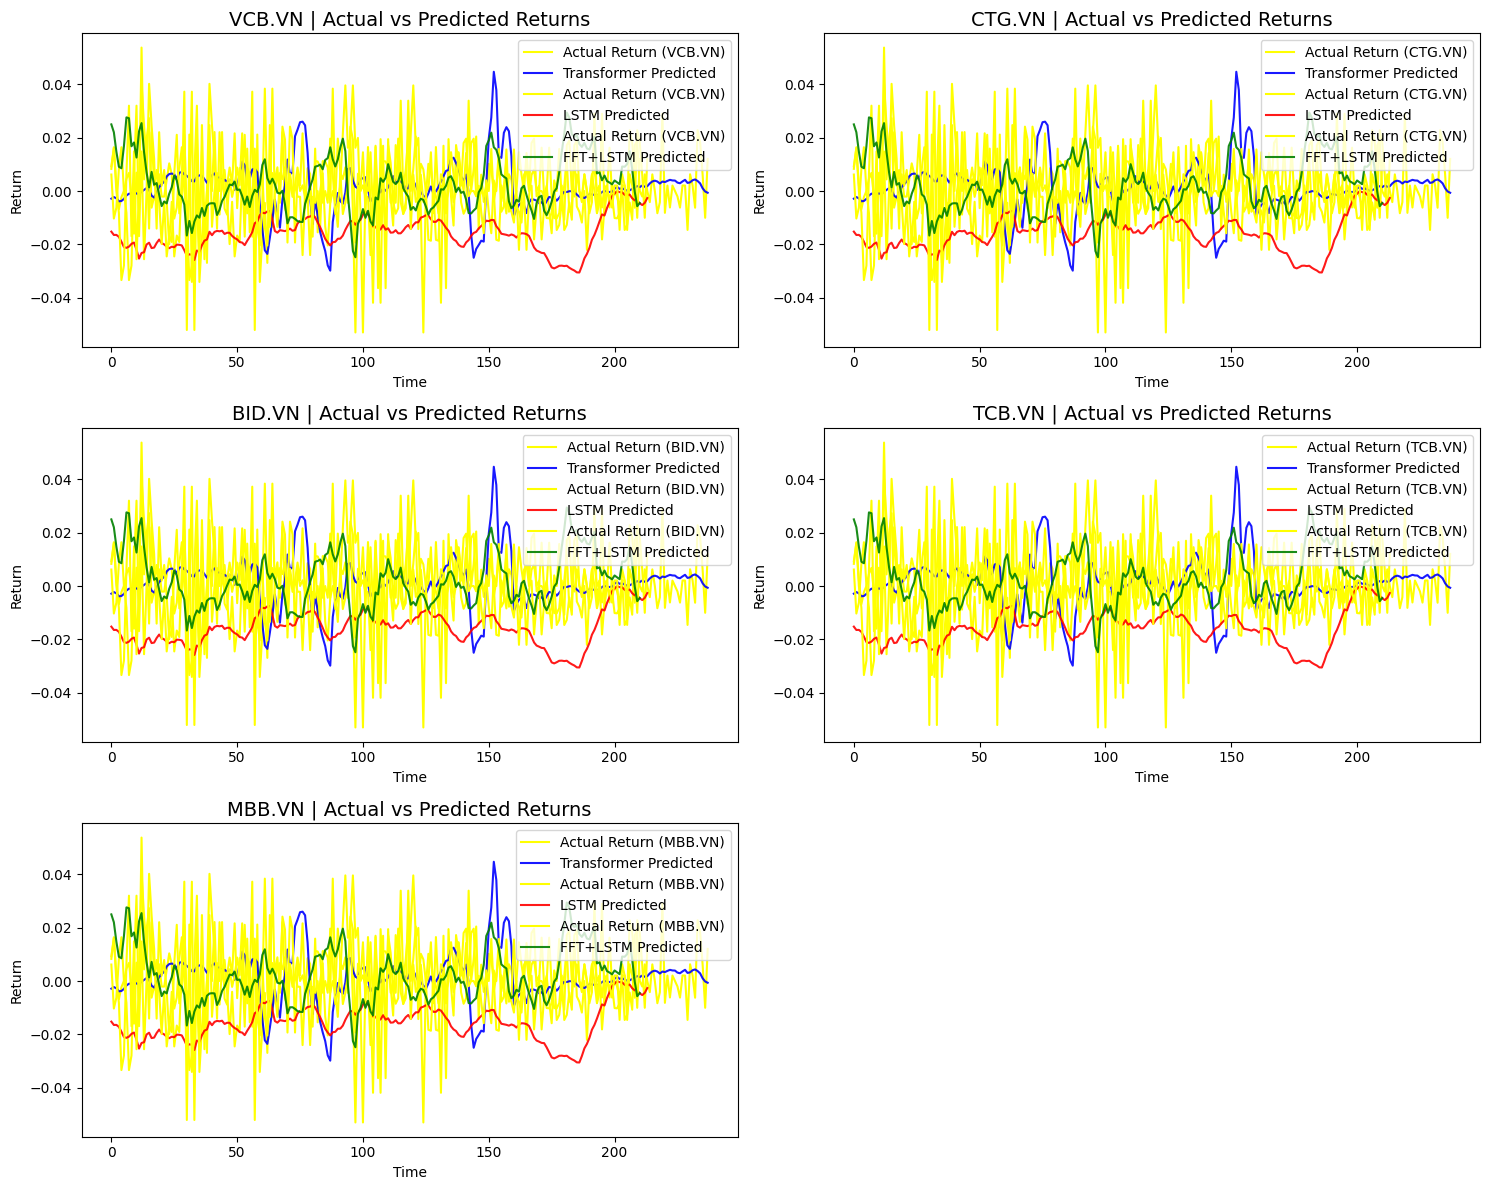

In [20]:
import matplotlib.pyplot as plt

# Visualization for each model and stock
plt.figure(figsize=(15, 12))

# Loop over all tickers and plot the actual vs predicted returns
for i, ticker in enumerate(tickers, 1):
    plt.subplot(3, 2, i)

    # Get the results for the current ticker from the all_actual_vs_predicted list
    results = [entry for entry in all_actual_vs_predicted if entry["Stock"] == ticker]

    for result in results:
        model = result["Model"]
        actual = result["Actual"]
        predicted = result["Predicted"]

        # Plot actual vs predicted returns for each model
        plt.plot(actual, label=f"Actual Return ({ticker})", color="yellow")  # Actual returns in orange
        if model == "LSTM":
            plt.plot(predicted, label=f"{model} Predicted", color="red", alpha=0.9)  # LSTM predictions in red
        elif model == "Transformer":
            plt.plot(predicted, label=f"{model} Predicted", color="blue", alpha=0.9)  # Transformer predictions in blue
        elif model == "FFT+LSTM":
            plt.plot(predicted, label=f"{model} Predicted", color="green", alpha=0.9)  # FFT+LSTM predictions in green

    # Customize the plot for each stock
    plt.title(f"{ticker} | Actual vs Predicted Returns", fontsize=14)
    plt.xlabel("Time")
    plt.ylabel("Return")
    plt.legend()

plt.tight_layout()
plt.show()
